In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torchxlstm import sLSTM, mLSTM, xLSTM 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy.io

# 2024.10.25 UPS torque
# 
# 

# 读取第一个上传的 .mat 文件以检查其内容   
emg_features_mat_path = 'D:\\ly\\sEMG\\SIAT-UPS\\emg_features_examples.mat'
emg_features_data = scipy.io.loadmat(emg_features_mat_path)

In [3]:
sEMG_data = emg_features_data['examples']
angles = emg_features_data['angle_labels']
torques = emg_features_data['torque_labels']

sEMG_values = sEMG_data.astype('float32')
sEMG_scaler = MinMaxScaler(feature_range=(0, 1))
sEMG_normalized = np.zeros_like(sEMG_data)
for i in range(9):
    scaler = MinMaxScaler(feature_range=(0, 1))
    sEMG_normalized[:, i, :] = scaler.fit_transform(sEMG_data[:, i, :])

joint_angles_values = angles.astype('float32')
angles_scaler = MinMaxScaler(feature_range=(0, 1))
angles_normalized = angles_scaler.fit_transform(joint_angles_values)

joint_torques_values = torques.astype('float32')
torques_scaler = MinMaxScaler(feature_range=(0, 1))
torques_normalized = torques_scaler.fit_transform(joint_torques_values)

len(sEMG_normalized), len(angles_normalized), len(torques_normalized)


(19952, 19952, 19952)

In [4]:
# 分割训练集和测试集
train_size = int(len(sEMG_normalized) * 0.8)
test_size = len(sEMG_normalized) - train_size

train_sEMG = sEMG_normalized[:train_size]
test_sEMG = sEMG_normalized[train_size:]

train_angles = angles_normalized[:train_size]
test_angles = angles_normalized[train_size:]

train_torques = torques_normalized[:train_size]
test_torques = torques_normalized[train_size:]

len(train_sEMG), len(test_sEMG), len(train_angles), len(test_angles), len(train_torques), len(test_torques)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


(15961, 3991, 15961, 3991, 15961, 3991)

In [5]:
def create_dataset(sEMG_data, angles_data, seq_len):
    dataX, dataY = [], []
    for i in range(len(sEMG_data) - seq_len + 1):
        a = sEMG_data[i:(i + seq_len)]
        dataX.append(a)
        dataY.append(angles_data[i + seq_len - 1])
    return torch.tensor(dataX, dtype=torch.float32), torch.tensor(dataY, dtype=torch.float32)


# UPS torques24.10.24

seq_len = 1926  # SIAT论文P4  a total of nine-channel sEMG signals were collected by using a wireless acquisition system sampled at 1926 Hz
trainX, trainY = create_dataset(train_sEMG, train_torques, seq_len)  
testX, testY = create_dataset(test_sEMG, test_torques, seq_len)

print("Training data shape:", trainX.shape, trainY.shape)
print("Testing data shape:", testX.shape, testY.shape)


# X_train, X_test, y_angles_train, y_angles_test, y_torques_train, y_torques_test
# Create data loaders
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

C:\Users\linhy\AppData\Local\Temp\ipykernel_30196\1582126785.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(dataX, dtype=torch.float32), torch.tensor(dataY, dtype=torch.float32)


Training data shape: torch.Size([14036, 1926, 9, 6]) torch.Size([14036, 8])
Testing data shape: torch.Size([2066, 1926, 9, 6]) torch.Size([2066, 8])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EMGModel(nn.Module):
    def __init__(self, input_channels, input_features, hidden_size, num_heads, model_type):
        super(EMGModel, self).__init__()
        self.input_projection = nn.Linear(input_channels * input_features, hidden_size)
        
        if model_type == 'xLSTM':
            self.rnn = xLSTM(hidden_size, hidden_size, num_heads, batch_first=True, layers='msm')
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif model_type == 'sLSTM':
            self.rnn = sLSTM(hidden_size, hidden_size, num_heads, batch_first=True)
        elif model_type == 'mLSTM':
            self.rnn = mLSTM(hidden_size, hidden_size, num_heads, batch_first=True)
        
        self.output = nn.Linear(hidden_size, 8)  # 假设我们预测单个关节角度
    
    def forward(self, x):
        batch_size, seq_len, input_channels, input_features = x.size()
        x = x.view(batch_size, seq_len, -1)
        x = self.input_projection(x)
        
        if isinstance(self.rnn, nn.LSTM):
            x, _ = self.rnn(x)
        else:
            x, _ = self.rnn(x)
        
        x = self.output(x[:, -1, :])
        return x
    
# 定义模型
input_channels = 9  # 电极数
input_features = 6  # 特征数
hidden_size = 32
num_heads = 2

models = {
    "LSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'LSTM'),
    "sLSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'sLSTM'),
    "mLSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'mLSTM'),
    "xLSTM": EMGModel(input_channels, input_features, hidden_size, num_heads, 'xLSTM'),
}

Using device: cuda


Training LSTM:   5%|▌         | 1/20 [00:03<00:59,  3.13s/it]

0.15025021913258862


Training LSTM:  10%|█         | 2/20 [00:06<00:54,  3.04s/it]

0.10834384747625786


Training LSTM:  15%|█▌        | 3/20 [00:09<00:51,  3.03s/it]

0.10223756515945334


Training LSTM:  20%|██        | 4/20 [00:12<00:48,  3.02s/it]

0.09782822888090095


Training LSTM:  25%|██▌       | 5/20 [00:15<00:45,  3.04s/it]

0.09193566057626433


Training LSTM:  30%|███       | 6/20 [00:18<00:42,  3.05s/it]

0.08532161539668234


Training LSTM:  35%|███▌      | 7/20 [00:21<00:39,  3.06s/it]

0.07937956900899552


Training LSTM:  40%|████      | 8/20 [00:24<00:36,  3.06s/it]

0.07645571216623817


Training LSTM:  45%|████▌     | 9/20 [00:27<00:33,  3.06s/it]

0.0719200838846934


Training LSTM:  50%|█████     | 10/20 [00:30<00:30,  3.06s/it]

0.0685003065507187


Training LSTM:  55%|█████▌    | 11/20 [00:33<00:27,  3.06s/it]

0.08198866327032442


Training LSTM:  60%|██████    | 12/20 [00:36<00:24,  3.05s/it]

0.07693204743070411


Training LSTM:  65%|██████▌   | 13/20 [00:39<00:21,  3.05s/it]

0.06794767666095582


Training LSTM:  70%|███████   | 14/20 [00:42<00:18,  3.05s/it]

0.07845867440072342


Training LSTM:  75%|███████▌  | 15/20 [00:45<00:15,  3.05s/it]

0.07168380494354051


Training LSTM:  80%|████████  | 16/20 [00:48<00:12,  3.05s/it]

0.06427431422377447


Training LSTM:  85%|████████▌ | 17/20 [00:51<00:09,  3.04s/it]

0.06286776566834561


Training LSTM:  90%|█████████ | 18/20 [00:54<00:06,  3.06s/it]

0.06152416116321904


Training LSTM:  95%|█████████▌| 19/20 [00:58<00:03,  3.06s/it]

0.06140972496304493


Training LSTM: 100%|██████████| 20/20 [01:01<00:00,  3.05s/it]

0.05780037030081837


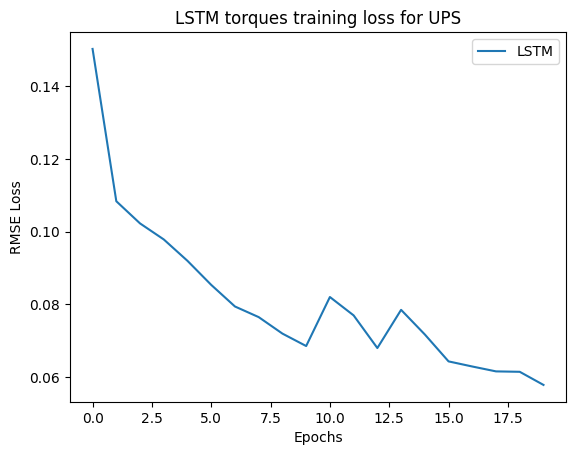

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


Training sLSTM:   5%|▌         | 1/20 [34:31<10:55:56, 2071.39s/it]

0.1503647937738


Training sLSTM:  10%|█         | 2/20 [1:08:52<10:19:35, 2065.32s/it]

0.12094925230825544


Training sLSTM:  15%|█▌        | 3/20 [1:42:55<9:42:14, 2054.97s/it] 

0.11171079492559569


Training sLSTM:  20%|██        | 4/20 [2:17:08<9:07:49, 2054.34s/it]

0.103906207948772


Training sLSTM:  25%|██▌       | 5/20 [2:52:27<8:39:23, 2077.57s/it]

0.10314272990739311


Training sLSTM:  30%|███       | 6/20 [3:27:48<8:08:12, 2092.31s/it]

0.09974174534400741


Training sLSTM:  35%|███▌      | 7/20 [4:02:33<7:32:48, 2089.89s/it]

0.10433141004815531


Training sLSTM:  40%|████      | 8/20 [4:38:02<7:00:28, 2102.39s/it]

0.10748417352236485


Training sLSTM:  45%|████▌     | 9/20 [5:13:30<6:26:56, 2110.63s/it]

0.108634437065083


Training sLSTM:  50%|█████     | 10/20 [5:48:20<5:50:42, 2104.26s/it]

0.09738862755679459


Training sLSTM:  55%|█████▌    | 11/20 [6:23:11<5:15:01, 2100.18s/it]

0.10049771075211422


Training sLSTM:  60%|██████    | 12/20 [6:57:21<4:37:58, 2084.83s/it]

0.09808651143211654


Training sLSTM:  65%|██████▌   | 13/20 [7:31:08<4:01:10, 2067.22s/it]

0.09246165625381515


Training sLSTM:  70%|███████   | 14/20 [8:05:15<3:26:07, 2061.18s/it]

0.09517027932421691


Training sLSTM:  75%|███████▌  | 15/20 [8:39:32<2:51:39, 2059.96s/it]

0.17751680013506987


Training sLSTM:  80%|████████  | 16/20 [9:13:11<2:16:30, 2047.69s/it]

0.11872308780972271


Training sLSTM:  85%|████████▌ | 17/20 [9:46:39<1:41:47, 2035.74s/it]

0.11776595865796471


Training sLSTM:  90%|█████████ | 18/20 [10:20:46<1:07:58, 2039.15s/it]

0.11534478701588309


Training sLSTM:  95%|█████████▌| 19/20 [10:55:03<34:04, 2044.32s/it]  

0.1224510805190385


Training sLSTM: 100%|██████████| 20/20 [11:28:47<00:00, 2066.40s/it]

0.11251553923493116


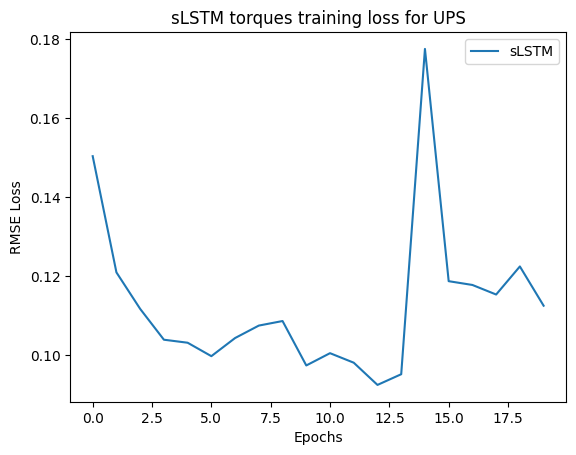

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


Training mLSTM:   5%|▌         | 1/20 [28:53<9:08:58, 1733.58s/it]

0.14377634676703646


Training mLSTM:  10%|█         | 2/20 [57:45<8:39:47, 1732.64s/it]

0.11631790529976922


Training mLSTM:  15%|█▌        | 3/20 [1:25:30<8:02:10, 1701.78s/it]

0.11096701432409789


Training mLSTM:  20%|██        | 4/20 [1:53:09<7:29:20, 1685.02s/it]

0.10320925997218156


Training mLSTM:  25%|██▌       | 5/20 [2:21:45<7:04:02, 1696.14s/it]

0.09785380277619897


Training mLSTM:  30%|███       | 6/20 [2:50:41<6:38:54, 1709.63s/it]

0.0951255430588641


Training mLSTM:  35%|███▌      | 7/20 [3:18:55<6:09:16, 1704.38s/it]

0.09301844329995958


Training mLSTM:  40%|████      | 8/20 [3:46:39<5:38:20, 1691.70s/it]

0.0895141120297519


Training mLSTM:  45%|████▌     | 9/20 [4:14:43<5:09:41, 1689.24s/it]

0.08645810307553996


Training mLSTM:  50%|█████     | 10/20 [4:43:23<4:43:05, 1698.58s/it]

0.08394348621520001


Training mLSTM:  55%|█████▌    | 11/20 [5:11:56<4:15:27, 1703.04s/it]

0.0821751484000151


Training mLSTM:  60%|██████    | 12/20 [5:39:39<3:45:27, 1690.96s/it]

0.08282730912144637


Training mLSTM:  65%|██████▌   | 13/20 [6:07:26<3:16:26, 1683.72s/it]

0.08020229365885749


Training mLSTM:  70%|███████   | 14/20 [6:36:00<2:49:17, 1692.83s/it]

0.08022414342514551


Training mLSTM:  75%|███████▌  | 15/20 [7:04:33<2:21:35, 1699.04s/it]

0.07883527008701025


Training mLSTM:  80%|████████  | 16/20 [7:32:25<1:52:43, 1690.83s/it]

0.07658453053192898


Training mLSTM:  85%|████████▌ | 17/20 [8:00:11<1:24:09, 1683.23s/it]

0.07398299336528022


Training mLSTM:  90%|█████████ | 18/20 [8:29:01<56:34, 1697.23s/it]  

0.07459095418717748


Training mLSTM:  95%|█████████▌| 19/20 [8:57:58<28:29, 1709.35s/it]

0.07601491747715505


Training mLSTM: 100%|██████████| 20/20 [9:25:51<00:00, 1697.59s/it]

0.2813715939074865


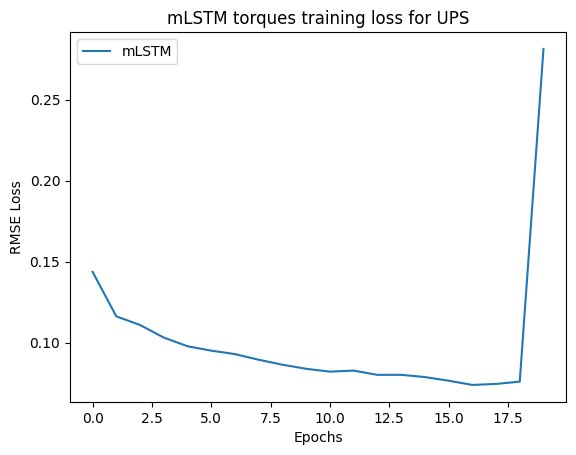

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


Training xLSTM:   5%|▌         | 1/20 [1:30:19<28:36:07, 5419.36s/it]

0.156328686467759


Training xLSTM:  10%|█         | 2/20 [3:00:56<27:09:00, 5430.00s/it]

0.11725755407444119


Training xLSTM:  15%|█▌        | 3/20 [4:28:31<25:15:51, 5350.09s/it]

0.10881960071945171


Training xLSTM:  20%|██        | 4/20 [5:57:47<23:47:16, 5352.28s/it]

0.10065369230539158


Training xLSTM:  25%|██▌       | 5/20 [7:27:26<22:20:28, 5361.87s/it]

0.09808666080419677


Training xLSTM:  30%|███       | 6/20 [8:56:19<20:48:51, 5352.26s/it]

0.10029251100723233


Training xLSTM:  35%|███▌      | 7/20 [10:25:23<19:19:01, 5349.32s/it]

0.09012933169351567


Training xLSTM:  40%|████      | 8/20 [11:55:06<17:52:02, 5360.18s/it]

0.0869344509489239


Training xLSTM:  45%|████▌     | 9/20 [13:24:17<16:22:11, 5357.37s/it]

0.08265363827894996


Training xLSTM:  50%|█████     | 10/20 [14:53:09<14:51:35, 5349.51s/it]

0.07890487126975108


Training xLSTM:  55%|█████▌    | 11/20 [16:22:22<13:22:33, 5350.43s/it]

0.07198345800526501


Training xLSTM:  60%|██████    | 12/20 [17:52:10<11:54:56, 5362.03s/it]

0.07388263006252985


Training xLSTM:  65%|██████▌   | 13/20 [19:21:28<10:25:25, 5360.77s/it]

0.07378821249116164


Training xLSTM:  70%|███████   | 14/20 [20:50:07<8:54:47, 5347.99s/it] 

0.47363870202347064


Training xLSTM:  75%|███████▌  | 15/20 [22:19:05<7:25:25, 5345.20s/it]

0.13995468368517183


Training xLSTM:  80%|████████  | 16/20 [23:49:08<5:57:30, 5362.56s/it]

0.11987092613600163


Training xLSTM:  85%|████████▌ | 17/20 [25:17:30<4:27:12, 5344.15s/it]

0.11598735840592761


Training xLSTM:  90%|█████████ | 18/20 [26:48:03<2:59:02, 5371.04s/it]

0.11364266976149698


Training xLSTM:  95%|█████████▌| 19/20 [28:19:35<1:30:07, 5407.39s/it]

0.11064572203181418


Training xLSTM: 100%|██████████| 20/20 [29:48:33<00:00, 5365.68s/it]  

0.10852787448444738


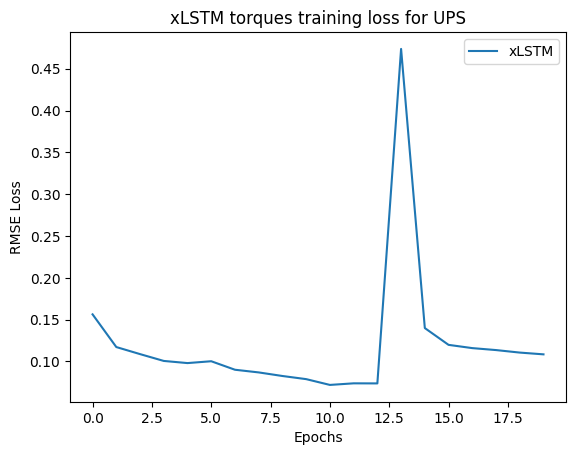

Returning from train_model: model type: <class '__main__.EMGModel'>, train_losses type: <class 'list'>


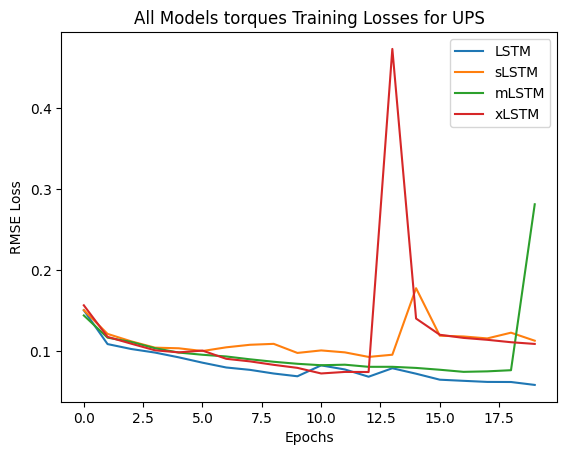

ValueError: non-broadcastable output operand with shape (16528,1) doesn't match the broadcast shape (16528,6)

In [7]:
import math
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
# Training process
def train_model(model, model_name, epochs, learning_rate, flag1, flag2):
    model = model.to(device)
    criterion = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model_name}'):
        model.train()
        epoch_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        torch.cuda.synchronize()
        lossp = math.sqrt(epoch_loss / len(train_loader))
        print(lossp)
        train_losses.append(lossp)
        torch.cuda.empty_cache()

    plt.plot(train_losses, label=model_name)
    plt.title(f'{model_name} {flag1} training loss for {flag2}')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE Loss')
    plt.legend()
    plt.show()

    print(f"Returning from train_model: model type: {type(model)}, train_losses type: {type(train_losses)}")
    return model, train_losses

# Train the models
trained_models = {}
all_train_losses = {}
flag1 = 'torques'
flag2 = 'UPS'
for model_name, model in models.items():
    trained_models[model_name], all_train_losses[model_name] = train_model(model, model_name, epochs=20, learning_rate=0.01, flag1=flag1, flag2=flag2)


# Plot losses for each model
plt.figure()
for model_name, train_losses in all_train_losses.items():
    plt.plot(train_losses, label=model_name)

# Plot all model losses compared
plt.title(f'All Models {flag1} Training Losses for {flag2}')
plt.xlabel('Epochs')
plt.ylabel('RMSE Loss')
plt.legend()
plt.show()

# Evaluate models on test data
def evaluate_model(model, data_loader):
    model = model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
    return predictions

test_predictions = {}
for model_name, model in trained_models.items():
    test_predictions[model_name] = evaluate_model(model, test_loader)

# Plot predictions for each model
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions and actual values
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    actual = scaler.inverse_transform(testY.numpy().reshape(-1, 1))

    plt.figure()
    plt.plot(actual, label='Actual')
    plt.plot(preds, label=model_name + ' Predictions')
    plt.title(f'{model_name} are predicted for {flag2} {flag1} with actual results')
    plt.legend()
    plt.show()


# Plot all model predictions compared
plt.figure()
plt.plot(actual, label='Actual')
for model_name, preds in test_predictions.items():
    # Inverse transform the predictions 
    preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
    plt.plot(preds, label=model_name + ' Predictions')

plt.title(f'All models are predicted for {flag2} {flag1} with actual results')
plt.legend()
plt.show()